<a href="https://colab.research.google.com/github/squaluz/Group-9C-Capstone/blob/main/Sem-Eval%202010%20Task8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Group 9C SGUS NUS Capstone Project 2022 
### Improve Demand Forecasting through Natural Language Processing for Panasonic

The objective of the project is to develop a technology to detect cause-effect relationship from news corpora using Lexicon based relation identification

Methodology: 
1.   Data Preparation
2.   Model Training
3. Model Optimisation
4. Model Evaluation


## Step 1: Data preparation

#### Data set suggested by Panasonic for this exercise is from https://www.kaggle.com/datasets/drtoshi/semeval2010-task-8-dataset

Data set comes with predefined labels e1 and e2, not limited to just cause-effect

#### Python libraries used

Panda - Data analysis manipulation library for Python

Numpy - Mathematical operations over arrays

In [1]:
import pandas as pd        #data analysis and manipulation library for Python
import numpy as np         #mathematical operations over arrays

#Global variables
train_data = []            #sentence for training with labels 
train_target = []          #labels for training data
test_data = []             #sentence for testing with labels  
test_target = []           #labels for testing data

#### Create data frames

In [2]:
#Import files into a dataframe
def import_text(file_txt):
    
    colnames=['ID', 'Text'] 
    
    df = pd.read_csv(file_txt
                       ,skip_blank_lines=True   #input files have emplty lines
                       ,header=None             #no haeders
                       ,sep='\t'                #tab delimited
                       ,engine='python'         #engine
                       ,quotechar='^'           #if there are doublequotes in the text
                       ,comment='Comment:'      #this is for human reader, we don't need
                       ,names=colnames          #preset columns we need
                      )
    print("Number of rows: ", len(df.index))

    return df

In [3]:
#clean ""
def clean_doublequotes(df):
    return df.replace('"', '', regex=True)

In [4]:
#clean tags e.g. (e2,e1) - to check why?
def clean_tags(df_column,braket_type):
    
    if braket_type == 'angle':
        pattern = r'<.*?>'
    elif braket_type == 'round':
        pattern = r'(\(.*?\))'
    else:
        raise Exception("angle or round")
    
    return df_column.str.replace(pattern, '', regex=True)

In [5]:
#create tuple of keys
keys = ('Other','Cause-Effect','Product-Producer','Entity-Origin','Instrument-Agency','Component-Whole','Content-Container','Entity-Destination','Member-Collection','Message-Topic')
#for i in range(len(keys)): print(i, keys[i])

In [6]:
def prepare_file(file_name,use):
    
    #Import training file into a dataframe
    df = import_text(file_name)

    #clean ""
    df = clean_doublequotes(df)

    # combine rows 1&2
    df['Clasification'] = df['ID'].shift(-1)

    #remove leftover rows
    df = df[df.Text.notna()]

    #clean tags e.g. <e2> - better option would be to keep them and use for more precise prediction
    df.Text = clean_tags(df.Text,braket_type='angle')

    #clean tags e.g. (e2,e1) - better option would be to keep them and use for more precise prediction
    df.Clasification = clean_tags(df.Clasification,braket_type='round')

    #Map Keys to numbers
    df['Clasification_ID'] = df.Clasification.map(lambda x: keys.index(x))

    #to use in thes same file
    if use == 'train':
        global train_data
        train_data = df.Text
        
        global train_target
        train_target = df.Clasification_ID
    elif use == 'test':
        global test_data
        test_data = df.Text
        
        global test_target
        test_target = df.Clasification_ID

    #check
    print('Output rows:', len(df.index))
  
    return df

#### Prepare Training file

In [ ]:
#prepare file
df_train = prepare_file('semeval2010task8_train.txt','train')

df_train.head(5)

FileNotFoundError: ignored

In [8]:
df_test = prepare_file('semeval2010task8_test.txt','test')

df_test.head(5)

Number of rows:  5434
Output rows: 2717


,ID,Text,Clasification,Clasification_ID
0,8001,The most common audits were about waste and re...,Message-Topic,9
2,8002,The company fabricates plastic chairs.,Product-Producer,2
4,8003,The school master teaches the lesson with a st...,Instrument-Agency,4
6,8004,The suspect dumped the dead body into a local ...,Entity-Destination,7
8,8005,Avian influenza is an infectious disease of bi...,Cause-Effect,1


## Step 2: training models

In [9]:
# use the TF-IDF vectorizer and create a pipeline that attaches it to a multinomial naive Bayes classifier
from sklearn.feature_extraction.text import TfidfVectorizer    #Convert a collection of raw documents to a matrix of TF-IDF features
from sklearn.naive_bayes import MultinomialNB                  #multinomial Naive Bayes classifier is suitable for classification with discrete features
from sklearn.pipeline import make_pipeline                     #Construct a Pipeline from the given estimators

#show data
import seaborn as sns; sns.set()                               #data visualization library based on matplotlib
import matplotlib.pyplot as plt                                #interactive plots 
from sklearn.metrics import confusion_matrix                   #Compute confusion matrix to evaluate the accuracy of a classification

### Train model 1: Multinomial Naive Bayes (standard parameters)

In [10]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [11]:
#TO READ: https://jakevdp.github.io/PythonDataScienceHandbook/05.04-feature-engineering.html

In [12]:
#With this pipeline, we can apply the model to the training data, and predict labels for the test data
model.fit(train_data, train_target)
labels = model.predict(test_data)

<Figure size 4800x4800 with 0 Axes>

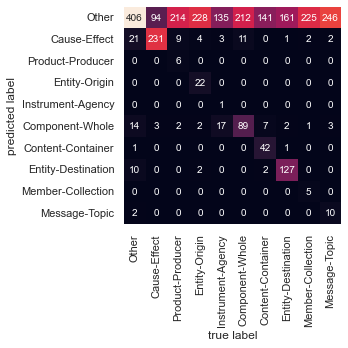

<Figure size 4800x4800 with 0 Axes>

In [13]:
#evaluate the performance of the estimator with confusion matrix between the true and predicted labels for the test data
plt.rcParams['font.size'] = '26'
mat = confusion_matrix(test_target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=keys, yticklabels=keys)

plt.xlabel('true label')
plt.ylabel('predicted label')

from matplotlib.pyplot import figure
figure(figsize=(6, 6), dpi=800)

In [14]:
accuracy_for_test_keys = np.mean(labels == test_target)
print("Multinomial Naive Bayes Model Accuracy = {} %".format(accuracy_for_test_keys*100))

Multinomial Naive Bayes Model Accuracy = 34.560176665439826 %


In [15]:
def predict_category(s, train=keys, model=model):
    pred = model.predict([s])
    return train[pred[0]]

In [16]:
df_test['Calculated_Clasification_ID'] = labels

In [17]:
df_test['Calculated_Clasification'] = df_test.Calculated_Clasification_ID.map(lambda x: keys[x])

In [18]:
df_test.head(10)

,ID,Text,Clasification,Clasification_ID,Calculated_Clasification_ID,Calculated_Clasification
0,8001,The most common audits were about waste and re...,Message-Topic,9,1,Cause-Effect
2,8002,The company fabricates plastic chairs.,Product-Producer,2,0,Other
4,8003,The school master teaches the lesson with a st...,Instrument-Agency,4,0,Other
6,8004,The suspect dumped the dead body into a local ...,Entity-Destination,7,7,Entity-Destination
8,8005,Avian influenza is an infectious disease of bi...,Cause-Effect,1,1,Cause-Effect
10,8006,The ear of the African elephant is significant...,Component-Whole,5,0,Other
12,8007,A child is told a lie for several years by the...,Product-Producer,2,0,Other
14,8008,"Skype, a free software, allows a hookup of mul...",Member-Collection,8,0,Other
16,8009,The disgusting scene was retaliation against h...,Component-Whole,5,0,Other
18,8010,This thesis defines the clinical characteristi...,Message-Topic,9,0,Other


### Train model 2: Multinomial Naive Bayes (optimized parameters)

In [19]:
#https://holypython.com/nbc/naive-bayes-classifier-optimization-parameters/

#https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/
#model1 = make_pipeline(CountVectorizer(ngram_range=(1,3)), TfidfVectorizer(), MultinomialNB())

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer


In [21]:
#Tokenizing text with scikit-learn we used CountVectorizer
count_vector = CountVectorizer()
train_counts = count_vector.fit_transform(train_data)

# Term Frequencies are calculated which has to be use_idf=True 
tf_transformer = TfidfTransformer(use_idf=True).fit(train_counts)
tf_train = tf_transformer.transform(train_counts)

#Term Frequency times Inverse Document Frequency to skipping redundant processing
tf_idf_transformer = TfidfTransformer()
tf_idf_train = tf_idf_transformer.fit_transform(train_counts)

#Training a classifier 
# Now we took Naive Bayes classifier which provides a nice baseline for this task
# We used the Multinomial Naive Bayes
#print (tf_idf_train)
#print (train_target)
multi_nb = MultinomialNB().fit(tf_idf_train, train_target)

# Combing the all CountVectorizer,TfidfTransformer,MultinomialNB with alpha value 0.01
#ngram_range The lower and upper boundary of the range of n-values is 1 and 3
text_classification = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,3))),
    ('tfidftransformer', TfidfTransformer(use_idf=True)),
    ('classification', MultinomialNB(alpha=0.01)),])
text_classification = text_classification.fit(train_data, train_target)
predicted = text_classification.predict(test_data)

# Naive Bayes predicted values is saving to csv file
np.savetxt("naive_bayes_predicted.csv", predicted, delimiter=",")

accuracy_for_test_keys = np.mean(predicted == test_target)
print("Multinomial Naive Bayes Model Accuracy = {} %".format(accuracy_for_test_keys*100))

Multinomial Naive Bayes Model Accuracy = 60.50791313949209 %


### Train model 3: Support Vector Machine

In [22]:
from sklearn.linear_model import SGDClassifier     #Linear classifiers (SVM, logistic regression, a.o.) with SGD training.
from sklearn.model_selection import GridSearchCV   #Exhaustive search over specified parameter values for an estimator. Important members are fit, predict.

In [23]:
# We are now implementing the Support Vector Machine 
parameters = {'vectorizer__ngram_range': [(1, 3), (1, 3)],'tfidftransformer__use_idf': (True, False),
'classification__alpha': (1e-2, 1e-3),'vectorizer__stop_words':('english',None)}

gs_clf = GridSearchCV(text_classification, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(train_data, train_target)

text_classification = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,3))),
    ('tfidftransformer', TfidfTransformer(use_idf=True)),
    ('classification', SGDClassifier(loss='squared_hinge',
     penalty='l2',alpha=2*1e-4, n_iter=800, random_state=100,eta0=0.0009)),])

roop = text_classification.fit(train_data, train_target)
svm_prediction = text_classification.predict(test_data)

#Support vector machine predicted values is saving to csv file
np.savetxt("svm.csv", svm_prediction, delimiter=",")

svm_accuracy = np.mean(svm_prediction == test_target)
print("Support Vector Machine Model Accuracy={} %".format(svm_accuracy*100))


TypeError: SGDClassifier.__init__() got an unexpected keyword argument 'n_iter'